# Project Name: Motorbike Ambulance Calls

<h3>Project description</h3>
Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.

<h3>Project Plan</h3>

<ol>
  <li>Getting acquainted with the data</li>
  <li>Data wrangling</li>
  <li>ARIMA Model</li>
  <li>Linear regression</li>
  <li>Decision trees. XGBoost</li>
</ol> 

Import libraries

In [115]:
import pandas as pd
from pandas.tseries import converter
import io

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Math calculations
import numpy as np
from scipy import stats

# Removing seasonality from the data
import matplotlib.dates as mdates
from numpy import polyfit

# Feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_squared_error

import pickle
import xgboost as xgb

Import the dataset

In [3]:
data = pd.read_csv(r'motorbike_ambulance_calls.csv')
print(len(data))

17379


# 1 Getting acquainted with the data

<h3>Dataset characteristics</h3>

<table style="width:100%">
  <tr>
    <th style="text-align:center">Column</th>
    <th style="text-align:center">Field</th> 
    <th style="text-align:center">Description</th>
  </tr>
  <tr>
    <td style="text-align:center">1</td>
    <td style="text-align:center">index</td>
    <td style="text-align:center">record index</td>
  </tr>
    <tr>
    <td style="text-align:center">2</td>
    <td style="text-align:center">date</td>
    <td style="text-align:center">date format (YYYY/DD/MM)</td>
  </tr>
    <tr>
    <td style="text-align:center">3</td>
    <td style="text-align:center">season</td>
    <td style="text-align:center">season (1:spring, 2:summer, 3:autumn, 4:winter)</td>
  <tr>
    <td style="text-align:center">4</td>
    <td style="text-align:center">yr</td>
    <td style="text-align:center">year (0: 2011, 1:2012)</td>
  </tr>
    <tr>
    <td style="text-align:center">5</td>
    <td style="text-align:center">mnth</td>
    <td style="text-align:center">month (1 to 12)</td>
  </tr>
    <tr>
    <td style="text-align:center">6</td>
    <td style="text-align:center">hr</td>
    <td style="text-align:center">hour (0 to 23)</td>
  </tr>
    <tr>
    <td style="text-align:center">7</td>
    <td style="text-align:center">holiday</td>
    <td style="text-align:center">whether day is holiday or not (1 - holiday, 0 - not holiday)</td>
  </tr>
    <tr>
    <td style="text-align:center">8</td>
    <td style="text-align:center">weekday</td>
    <td style="text-align:center">day of the week (1 - Monday)</td>
  </tr>
    <tr>
    <td style="text-align:center">9</td>
    <td style="text-align:center">workingday</td>
    <td style="text-align:center">if day is neither weekend nor holiday is 1, otherwise is 0</td>
  </tr>
    <tr>
    <td style="text-align:center">10</td>
    <td style="text-align:center">weathersit</td>
    <td>
      <ol>
      <li style="text-align:center">Clear, Few clouds, Partly cloudy, Partly cloudy</li>
      <li style="text-align:center">Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist</li>
      <li style="text-align:center">Light Snow, Light Rain + Thunderstorm + Scattered clouds,<br> Light Rain + Scattered clouds</li>
      <li style="text-align:center">Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog</li>
      </ol> 
    </td>
  </tr>
    <tr>
    <td style="text-align:center">11</td>
    <td style="text-align:center">temp</td>
    <td style="text-align:center">normalized temperature in Celsius. The values are divided to 41 (max)</td>
  </tr>
    <tr>
    <td style="text-align:center">12</td>
    <td style="text-align:center">atemp</td>
    <td style="text-align:center">normalized feeling temperature in Celsius. The values are divided to 50 (max)</td>
  </tr>
    <tr>
    <td style="text-align:center">13</td>
    <td style="text-align:center">hum</td>
    <td style="text-align:center">normalized humidity. The values are divided to 100 (max)</td>
  </tr>
    <tr>
    <td style="text-align:center">14</td>
    <td style="text-align:center">windspeed</td>
    <td style="text-align:center">normalized wind speed. The values are divided to 67 (max)</td>
  </tr>
    <tr>
    <td style="text-align:center">15</td>
    <td style="text-align:center">cnt</td>
    <td style="text-align:center">count of total ambulance calls</td>
  </tr>

In [4]:
data.head(3)

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/11,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/11,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/11,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


Let's take a first look at the distribution of ambulance calls

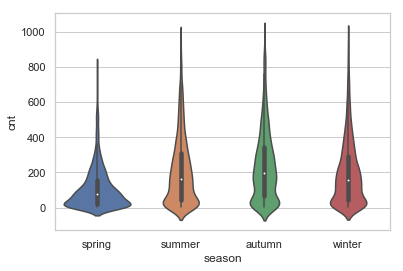

In [5]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=data['season'], y=data['cnt'], data=data)

From the histograms and violin plots, we can notice that:


1.   there is no Normal distribution of our target feature
2.   distributions by season differ from each other

Let's convert our date to DateTime format readable by python and set it as an index in our DataFrame so that it much easier visualize our time series.

In [6]:
not_a_time = np.datetime64("NaT")
data['datetime'] = not_a_time

for i in range(len(data)):
    datetime_list = []
    datetime_list = re.split("[%s]" % ("".join('/')), data.iloc[i]['date'])
    if data.iloc[i]['yr'] == 0:
        data.at[i, 'datetime'] = pd.Timestamp(year=2011, month=int(data.iloc[i]['mnth']), day=int(datetime_list[1]), hour=int(data.iloc[i]['hr']))
    elif data.iloc[i]['yr'] == 1:
        data.at[i, 'datetime'] = pd.Timestamp(year=2012, month=int(data.iloc[i]['mnth']), day=int(datetime_list[1]), hour=int(data.iloc[i]['hr']))
    
data = data.set_index('datetime')
data.head(3)

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,1/1/11,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01 01:00:00,2,1/1/11,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01 02:00:00,3,1/1/11,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


Now we can visualize our time series and see how our target feature behaves itself during the time period. Also, let's compare the number of ambulance calls with a temperature and humidity degree.

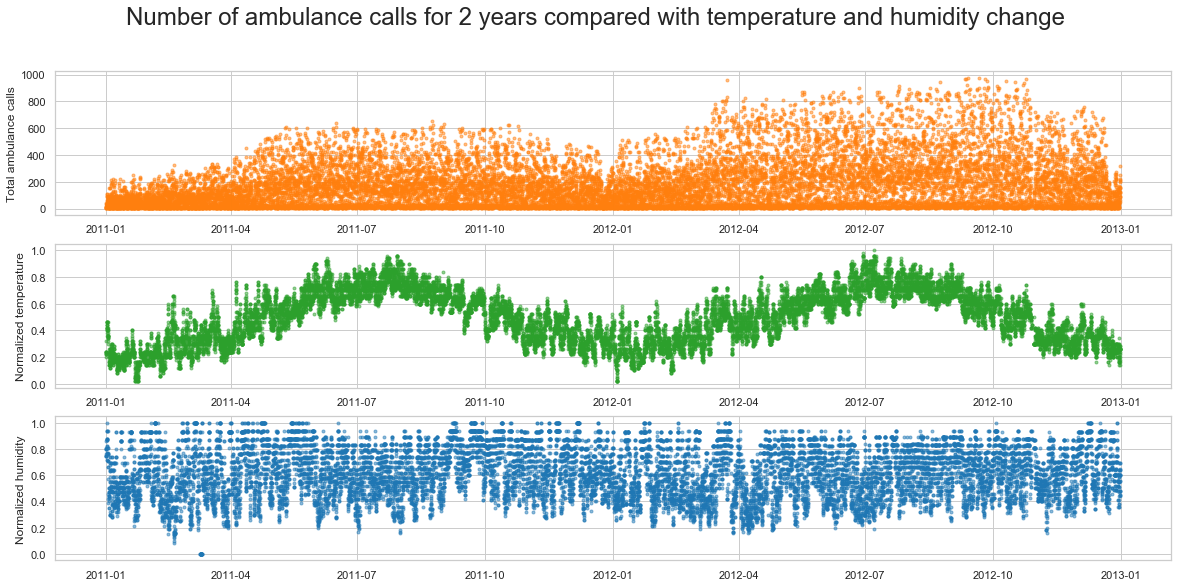

In [7]:
converter.register()
fig, axes = plt.subplots(3, 1, figsize=(20, 9))
fig.suptitle("Number of ambulance calls for 2 years compared with temperature and humidity change", fontsize=24)

axes[0].plot(data['cnt'], marker='.', alpha=0.5, linestyle='None', color='#ff7f0e')
axes[0].set_ylabel('Total ambulance calls')

axes[1].plot(data['temp'], marker='.', alpha=0.5, linestyle='None', color='#2ca02c')
axes[1].set_ylabel('Normalized temperature')

axes[2].plot(data['hum'], marker='.', alpha=0.5, linestyle='None', color='#1f77b4')
axes[2].set_ylabel('Normalized humidity')

fig.subplots_adjust(top=0.88)
plt.show()

We can already see some interesting patterns emerged. With increasing temperature, the number of ambulance calls increases too. It let us to the conclusion that our target feature is seasonally sensitive.

Let's zoom in the data to hourly perspective. 

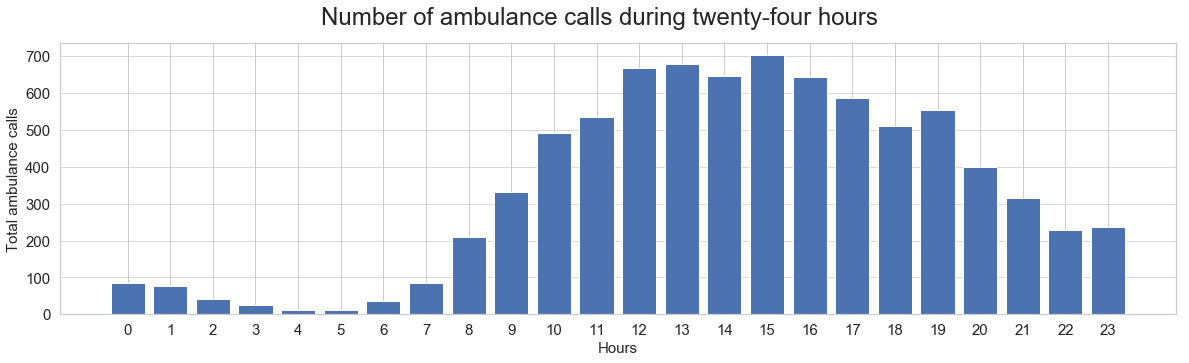

In [9]:
cnt_day = data.loc['2012-06-02']

fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle("Number of ambulance calls during twenty-four hours", fontsize=24)
plt.bar(cnt_day['hr'], cnt_day['cnt'])
plt.xticks(cnt_day['hr'])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hours',fontsize=15)
plt.ylabel('Total ambulance calls',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.subplots_adjust(top=0.88)
plt.show()

Obviously there is a daily seasonality. The number of ambulance calls varies throughout the day.

Let's take a look at our target feature from a slight distant perspective. We will resample our dataset by day, week, month and year

In [10]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
#     rolling_std =  series.rolling(window=n).std()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.legend(loc="upper left")
    plt.grid(True)

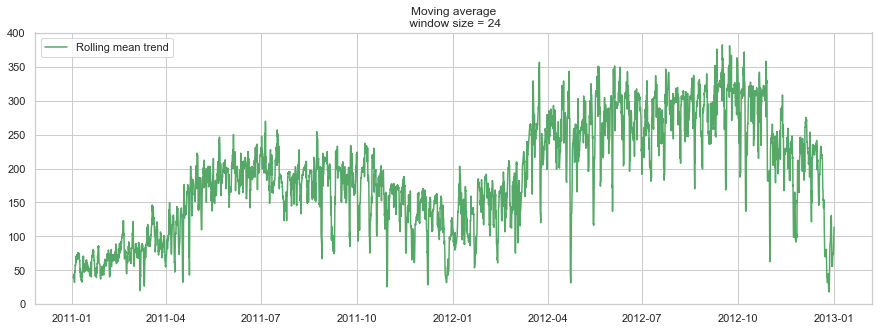

In [11]:
plotMovingAverage(data['cnt'], 24) # resample by day

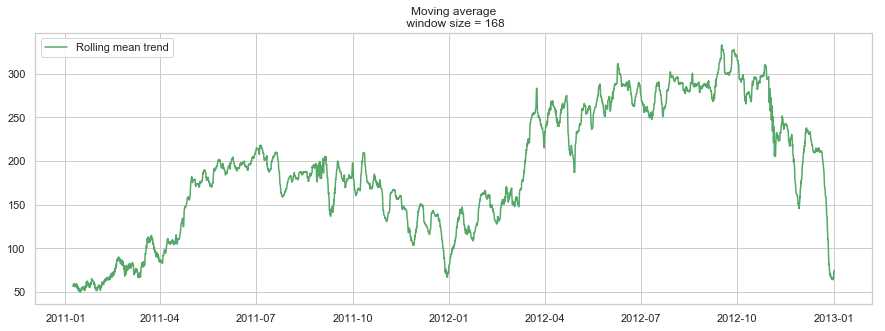

In [12]:
plotMovingAverage(data['cnt'], 24*7) # resample by week

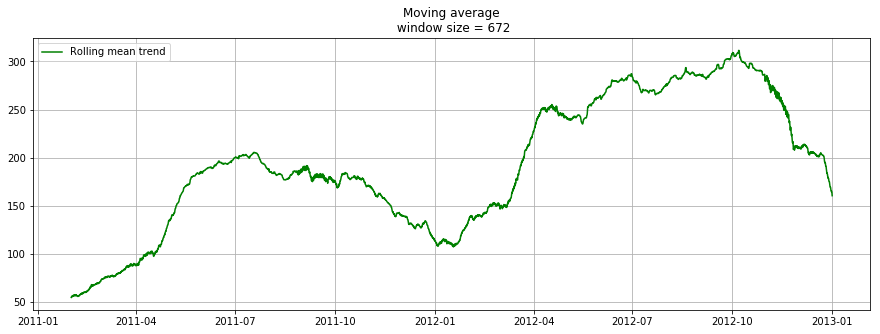

In [39]:
plotMovingAverage(data['cnt'], 24*7*4) # resample by month

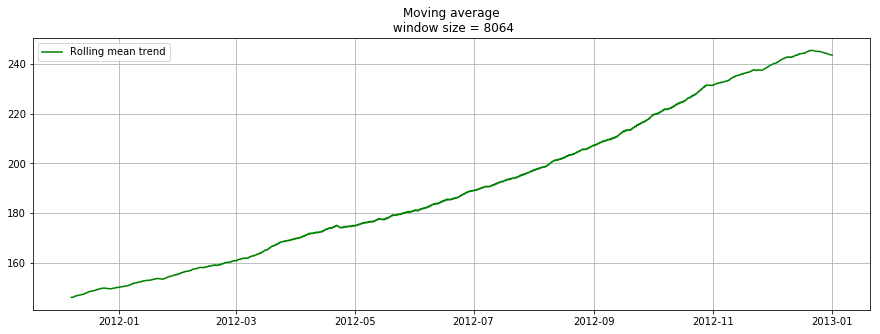

In [40]:
plotMovingAverage(data['cnt'], 24*7*4*12) # resample by year

This approach made the data more grouped. Now we can clearly see the yearly seasonal trend. 

# 2 Data wrangling

Zoom Out the data to get a daily scale

In [16]:
data.reset_index()

for row in data:
    data['date'] = pd.to_datetime(data['date'])

data = data.set_index('date')
# data.head(3)

In [17]:
# Create the column 'cnt' and sum the ambulance calls by day
cnt_by_day = data['cnt'].resample('d').sum()
cnt_by_day = cnt_by_day.to_frame(name = 'cnt')
cnt_by_day.shape

(731, 1)

In [18]:
# Create the column 'windspeed' and calculate a mean of the wind speed by day
windspeed_by_day = round(data['windspeed'].resample('d').mean(), 4)
windspeed_by_day = windspeed_by_day.to_frame(name = 'windspeed')
windspeed_by_day.shape

(731, 1)

In [19]:
# Create the column 'hum' and calculate a mean of the humidity by day
hum_by_day = round(data['hum'].resample('d').mean(), 2)
hum_by_day = hum_by_day.to_frame(name = 'hum')
hum_by_day.shape

(731, 1)

In [20]:
# Create the column 'atemp' and calculate a mean of the feeling temperature by day
atemp_by_day = round(data['atemp'].resample('d').mean(), 2)
atemp_by_day = atemp_by_day.to_frame(name = 'atemp')
atemp_by_day.shape

(731, 1)

In [21]:
# Create the column 'temp' and calculate a mean of the temperature by day
temp_by_day = round(data['temp'].resample('d').mean(), 2)
temp_by_day = temp_by_day.to_frame(name = 'temp')
temp_by_day.shape

(731, 1)

Create the column 'weathersit' and select a mode of the weather sit by day because it is a categorical variable

Trying to apply .resample('d').mode() I got an error with a note that mode() can't be applied to the column.
An interesting fact that this method worked on some part of data and on another part didn't.

After a long term investigation, I found that the data set is incomplete.
There is only one observation in 2012-10-29 for 00 hours. Let's take a closer look at the data for this day.

In [22]:
data.loc['2012-10-29']

index          15884
season        winter
yr                 1
mnth              10
hr                 0
holiday            0
weekday            1
workingday         1
weathersit         3
temp            0.44
atemp         0.4394
hum             0.88
windspeed     0.3582
cnt               22
Name: 2012-10-29 00:00:00, dtype: object

So that I came up with an algorithm that helped me to avoid this issue.

In [24]:
daterange = pd.date_range('2011-01-01', '2012-10-28')
weathersit_day_1 = pd.DataFrame()
weathersit_by_day_1 = pd.DataFrame()

for single_date in daterange:
    weathersit_value_1 = data.loc[single_date.strftime("%Y-%m-%d")]['weathersit'].mode().values[0]
    weathersit_day_1 = pd.DataFrame({'weathersit': weathersit_value_1}, index = [single_date.strftime("%Y-%m-%d")])
    weathersit_by_day_1 = weathersit_by_day_1.append(weathersit_day_1)

weathersit_by_day_1.shape

(667, 1)

In [25]:
daterange = pd.date_range('2012-10-30', '2012-12-31')
weathersit_day_2 = pd.DataFrame()
weathersit_by_day_2 = pd.DataFrame()

for single_date in daterange:
    weathersit_value_2 = data.loc[single_date.strftime("%Y-%m-%d")]['weathersit'].mode().values[0]
    weathersit_day_2 = pd.DataFrame({'weathersit': weathersit_value_2}, index = [single_date.strftime("%Y-%m-%d")])
    weathersit_by_day_2 = weathersit_by_day_2.append(weathersit_day_2)

weathersit_by_day_2.shape

(63, 1)

In [26]:
eathersit_day_3 = pd.DataFrame()
weathersit_value_3 = data.loc['2012-10-29']['weathersit']
weathersit_day_3 = pd.DataFrame({'weathersit': weathersit_value_3}, index = ['2012-10-29'])

weathersit_day_3

,weathersit
2012-10-29,3


In [27]:
weathersit_by_day = pd.concat([weathersit_by_day_1, weathersit_by_day_2], axis=0)
weathersit_by_day = pd.concat([weathersit_by_day, weathersit_day_3], axis=0, sort=True)
weathersit_by_day.shape

(731, 1)

In [28]:
# Create the column 'workingday' and get the first value from the subset of working days values
workingday_by_day = data['workingday'].resample('d').first()
workingday_by_day = workingday_by_day.to_frame(name = 'workingday')
workingday_by_day.shape

(731, 1)

In [29]:
# Create the column 'weekday' and get the first value from the subset of week days values
weekday_by_day = data['weekday'].resample('d').first()
weekday_by_day = weekday_by_day.to_frame(name = 'weekday')
weekday_by_day.shape

(731, 1)

In [30]:
# Create the column 'holiday' and get the first value from the subset of holidays values
holiday_by_day = data['holiday'].resample('d').first()
holiday_by_day = holiday_by_day.to_frame(name = 'holiday')
holiday_by_day.shape

(731, 1)

In [31]:
# Create the column 'mnth' and get the first value from the subset of months
mnth_by_day = data['mnth'].resample('d').first()
mnth_by_day = mnth_by_day.to_frame(name = 'mnth')
mnth_by_day.shape

(731, 1)

In [32]:
# Create the column 'yr' and get the first value from the subset of years
yr_by_day = data['yr'].resample('d').first()
yr_by_day = yr_by_day.to_frame(name = 'yr')
yr_by_day.shape

(731, 1)

In [33]:
# Create the column 'season' and get the first value from the subset of seasons
season_by_day = data['season'].resample('d').first()
season_by_day = season_by_day.to_frame(name = 'season')
season_by_day.shape

(731, 1)

In [34]:
# Merge the DataFrame by day
data_by_day = pd.DataFrame(index=season_by_day.index)
data_by_day = data_by_day.join(season_by_day).join(yr_by_day).join(mnth_by_day).join(holiday_by_day).join(weekday_by_day).join(workingday_by_day).join(weathersit_by_day).join(temp_by_day).join(atemp_by_day).join(hum_by_day).join(windspeed_by_day).join(cnt_by_day)
data_by_day.head(3)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
date,,,,,,,,,,,,
2011-01-01,spring,0,1,0,6,0,1,0.34,0.36,0.81,0.1604,985
2011-01-02,spring,0,1,0,0,0,2,0.36,0.35,0.70,0.2485,801
2011-01-03,spring,0,1,0,1,1,1,0.20,0.19,0.44,0.2483,1349


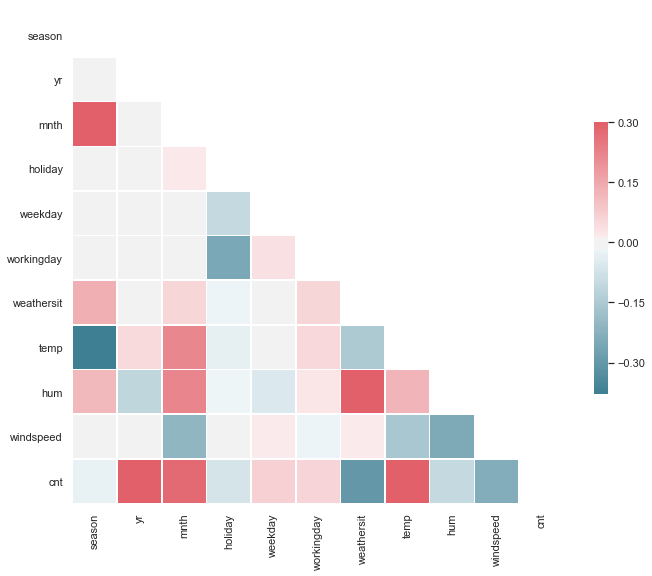

In [118]:
sns.set(style="white")
corr = data_by_day.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

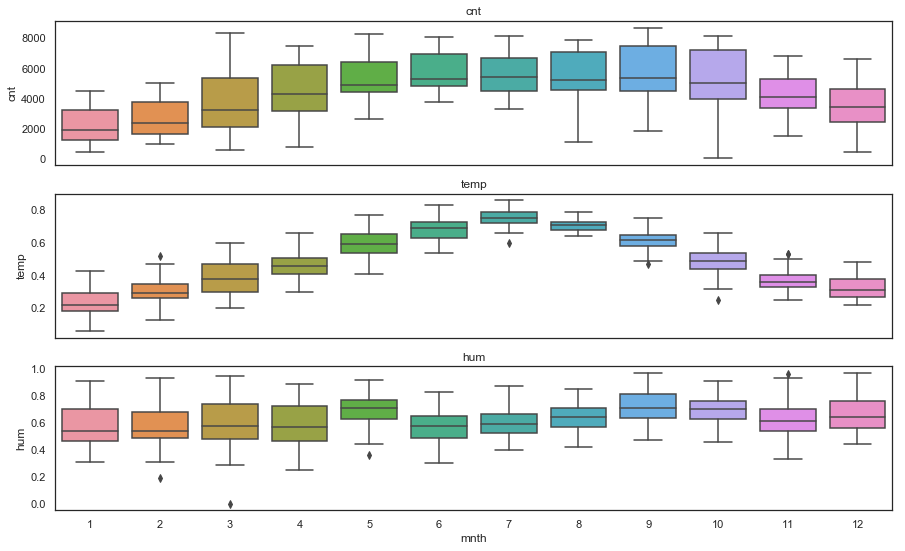

In [119]:
# These box plots confirm the yearly seasonality that we saw in earlier plots and provide some additional insights:

fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
for name, ax in zip(['cnt', 'temp', 'hum'], axes):
  sns.boxplot(data=data_by_day, x = 'mnth',  y=name, ax=ax)
  ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
  if ax != axes[-1]:
    ax.set_xlabel('')

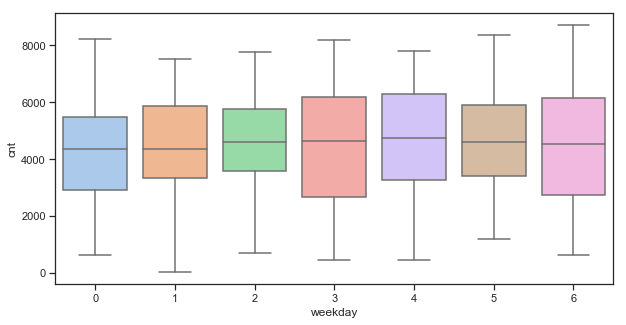

In [122]:
plt.figure(figsize=(10, 5))
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=data_by_day, x='weekday', y='cnt')
plt.show()

# 3 ARIMA Model

Проверяем ряд на стационарность по критерию Дики-Фуллера
<p>Гипотеза о стационарности временного ряда yt состоит в проверке основной гипотезы вида H0:ρ=1.</p>
Критерий Дикки-Фуллера используется при проверке гипотезы о наличия единичных корней.
Проверкой наличия единичных корней называется задача проверки основной гипотезы вида
H0:ρ=1 для модели авторегрессии первого порядка

Критерий Дики-Фуллера: p=0.342743


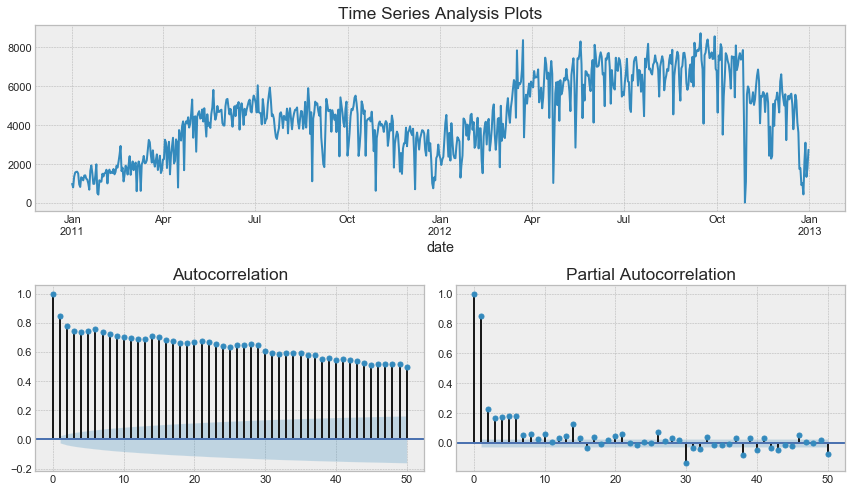

In [45]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(data_by_day['cnt'], lags=50)

Исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. 
Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

Критерий Дики-Фуллера: p=0.318112
Оптимальный параметр преобразования Бокса-Кокса: 0.883694


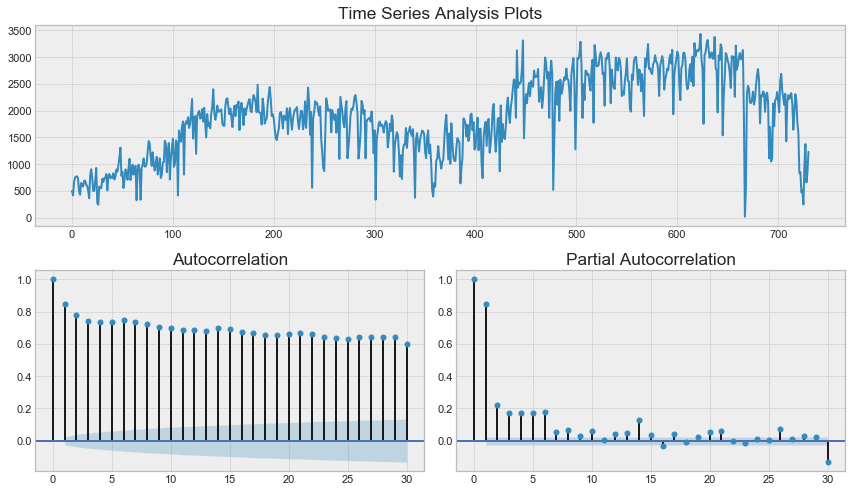

In [50]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data_boxcox = data_by_day['cnt'].copy()
# data_boxcox = rolling_mean_days.copy()
data_boxcox['cnt_box'], lmbda = scs.boxcox(data_by_day['cnt'] +1) # прибавляем единицу, так как в исходном ряде есть нули

tsplot(data_boxcox.cnt_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.783540


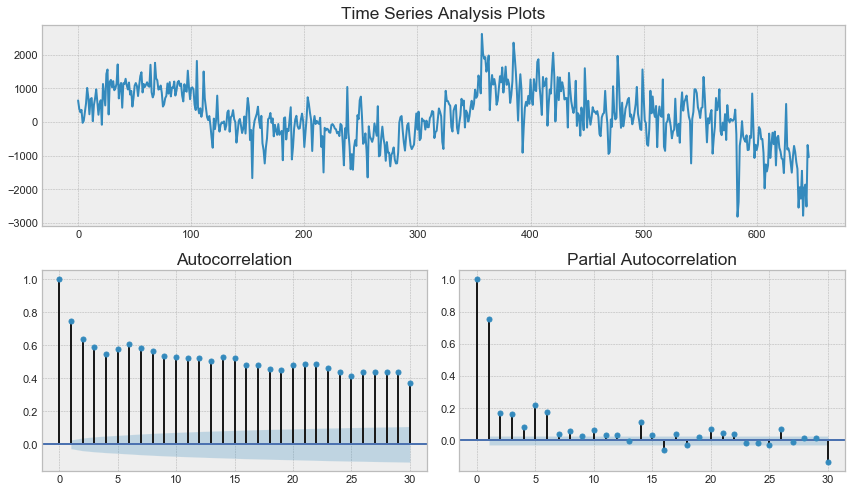

In [51]:
data_boxcox['cnt_box_season'] = data_boxcox.cnt_box - shift(data_boxcox.cnt_box, 7*4*3, cval=np.NaN)
tsplot(data_boxcox.cnt_box_season[7*4*3:], lags=30)

Критерий Дики-Фуллера: p=0.000394


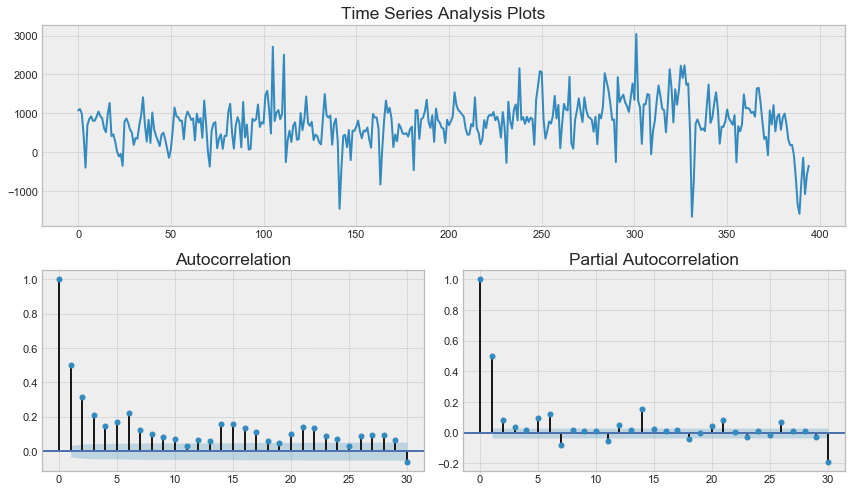

In [52]:
data_boxcox['cnt_box_year'] = data_boxcox.cnt_box - shift(data_boxcox.cnt_box, 7*4*12, cval=np.NaN)
tsplot(data_boxcox.cnt_box_year[7*4*12:], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности

In [81]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data_boxcox.cnt_box, order=(5, 1, 6), 
                                        seasonal_order=(4, 1, 2, 30)).fit(disp=-1)
print(best_model.summary())  

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  731
Model:             SARIMAX(5, 1, 6)x(4, 1, 2, 30)   Log Likelihood               -5204.571
Date:                            Mon, 23 Mar 2020   AIC                          10445.141
Time:                                    14:09:41   BIC                          10527.061
Sample:                                         0   HQIC                         10476.808
                                            - 731                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2564      0.263      0.975      0.329      -0.259       0.772
ar.L2          1.1417      0.106   

In [84]:
with open('model_SARIMA.pickle', 'wb') as f:
    pickle.dump(best_model, f)

Проверим остатки модели:

остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

Критерий Дики-Фуллера: p=0.000000


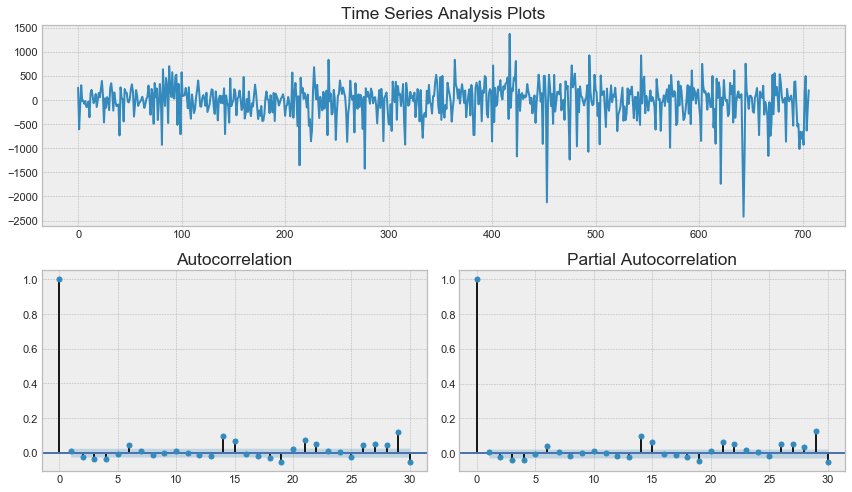

In [82]:
tsplot(best_model.resid[24:], lags=30)

Проверим остатки данной модели на соответствие «белому шуму». проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом».

In [85]:
q_test = sm.tsa.stattools.acf(best_model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
q_stat = pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
print(len(q_stat))
q_stat.head()

40


,Q-stat,p-value
0,0.060397,0.805869
1,0.511734,0.774245
2,1.588176,0.662074
3,2.475321,0.649060
4,2.491870,0.777719


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».

Построения прогноза и отрисовки графика

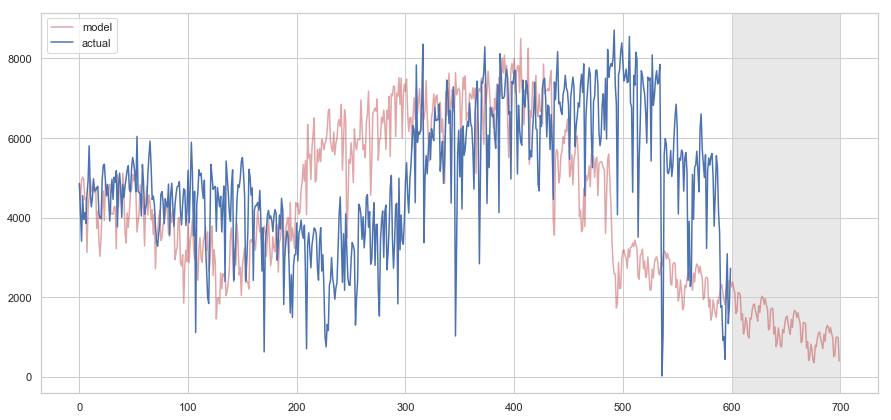

In [100]:
data_slice = data_by_day.copy()
data_slice["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = pd.Series(invboxcox(best_model.predict(start = data_slice['cnt'].shape[0], end = data_slice['cnt'].shape[0]+200), lmbda))
forecast = pd.Series(data_slice.arima_model.append(forecast).values[-700:])
actual = data_slice['cnt'].values[-600:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', alpha=0.5, label="model")
# plt.title("SARIMA model\n Mean absolute error {} cnt".format(round(mean_absolute_error(data_slice.dropna().cnt, data_slice.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# 4 Linear regression

In [101]:
le = LabelEncoder() 
  
data_by_day['season']= le.fit_transform(data_by_day['season'])
data_by_day.head(3)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
date,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,1,0.34,0.36,0.81,0.1604,985
2011-01-02,1,0,1,0,0,0,2,0.36,0.35,0.70,0.2485,801
2011-01-03,1,0,1,0,1,1,1,0.20,0.19,0.44,0.2483,1349


In [102]:
data_by_day = data_by_day.drop(['atemp'], axis=1)

In [105]:
test_size=0.2
test_index = int(len(data_by_day)*(1-test_size))

data = data_by_day.reset_index(drop=True).copy()

X_train = data.loc[:test_index].drop(["cnt"], axis=1)
y_train = data.loc[:test_index]["cnt"]
X_test = data.loc[test_index:].drop(["cnt"], axis=1)
y_test = data.loc[test_index:]["cnt"]

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

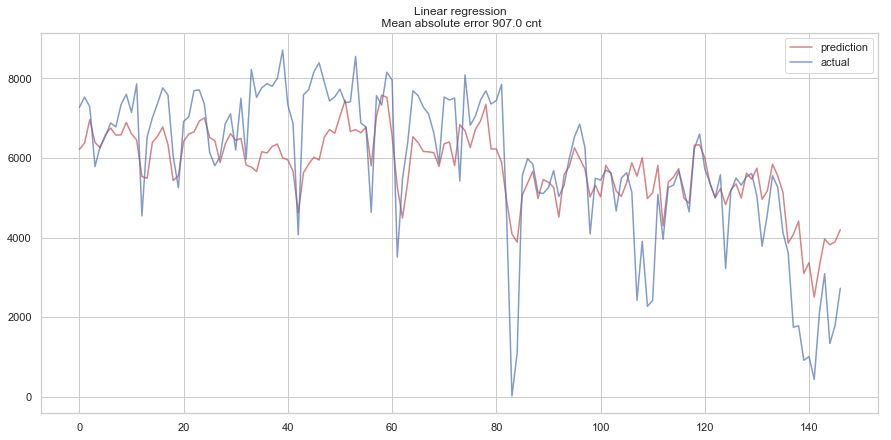

In [107]:
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", alpha=0.7, label="prediction")
plt.plot(y_test.values, alpha=0.7, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} cnt".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True)

# 5 Decision trees. XGBoost

In [108]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [109]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (585, 10)
Size of each fold: 117

Splitting the first 2 chunks at 1/2
Size of train + test: (234, 10)

Splitting the first 3 chunks at 2/3
Size of train + test: (351, 10)

Splitting the first 4 chunks at 3/4
Size of train + test: (468, 10)

Splitting the first 5 chunks at 4/5
Size of train + test: (585, 10)
Wall time: 61.1 ms


1125.624204156335

In [113]:
def XGB_forecast(data, test_size=0.2, scale=1.96):

      
    test_index = int(len(data)*(1-test_size))
    
    data = data.reset_index(drop=True).copy()

    X_train = data.loc[:test_index].drop(["cnt"], axis=1)
    y_train = data.loc[:test_index]["cnt"]
    X_test = data.loc[test_index:].drop(["cnt"], axis=1)
    y_test = data.loc[test_index:]["cnt"]
    
      
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
#     cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train, alpha=0.5, label="pred_train")
    plt.plot(y_train, alpha=0.5, label="y_train")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, alpha=0.5, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), alpha=0.5, label="y_test")
    plt.plot(Anomalies, "ro", alpha=0.5, markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} cnt".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

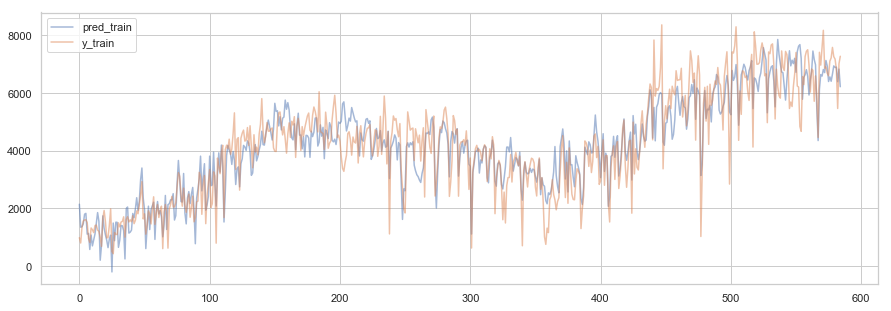

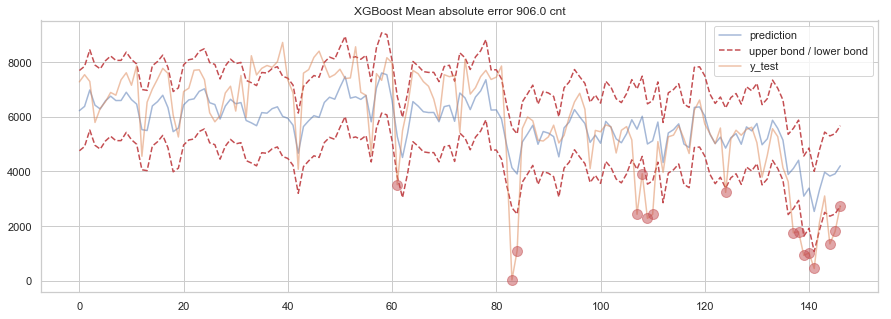

In [116]:
XGB_forecast(data, test_size=0.2)